# 1. XGBoost
[XGBoost](https://en.wikipedia.org/wiki/XGBoost) (e**X**treme **G**radient **Boost**ing) is a variant of GBM released in 2014 and dominated competitions in 2015. XGBoost develops an unique tree mechanic using both [gradient](https://en.wikipedia.org/wiki/Gradient) and [hessian](https://en.wikipedia.org/wiki/Hessian_matrix) of the loss function (these two terms refer to the first and second order derivatives in the context of univariate Calculus), while inherits the boosting process from GBM. Until now, it is still widely used by Data Scientists to achive state-of-the-art performance on tabular datasets.

## 1.1. Algorithm

### Objective function
XGBoost's authors strongly emphasize the role of regularization, which is usually treated less carefully in other tree packages. The objective function at step $t$ is defined so that it consists of two components, the loss term $\mathcal{L}$ and the regularization term $\mathcal{R}$.

*Loss term*. There are a lot of choices for loss functions, but let's start with the most friendly one, sum squared error. For each observation $\mathbf{s}_n$, the corresponding gradient is $g_n=\hat{y}_n-y_n$ (refers to the residual) and hessian is $h_n=1$ (refers to the size); the same idea can be applied to understand other loss functions. In general, due to the complexity of loss functions, XGBoost takes their second-order Taylor approximation. Notice that $\mathcal{L}\left(\hat{y}_n^{(t-1)}\right)$ is a constant and is not going to be considered when minimizing the loss term.

$$\begin{align}
\mathcal{L}\left(\hat{y}_n^{(t-1)}+f(\mathbf{s}_n)\right)
\approx\mathcal{L}\left(\hat{y}_n^{(t-1)}\right)+g_n^{(t)}f(\mathbf{s}_n)+\frac{1}{2}h_n^{(t)}f(\mathbf{s}_n)^2
\end{align}$$

*Regularization term*. We denote $M$ - the number of leaves and $w_m$ - the predicted value by $m^{th}$ leaf ($m=1,2,\dots,M$). The regularization term is defined using tree complexity as follow:

$$\mathcal{R}(f)=\gamma M+\frac{1}{2}\lambda\sum_{m=1}^{M}{w_m^2}$$

Now we have prepared $\mathcal{L}$ and $\mathcal{R}$, the next step is to adding them up. Unfortunately, these two term are indexed differently. Notice that all samples in a leaf get the same prediction, we change the index of $\mathcal{L}$ by defining $G_m$ and $H_m$, the sum of sample gradients and sample hessians in the leaf $m^{th}$.

$$\begin{align}
\mathcal{O}^{(t)}
&= \mathcal{L}^{(t)}+\mathcal{R}^{(t)} \\
&= \left(\sum_{n=1}^{N}g_n f(\mathbf{s}_n)+\sum_{n=1}^{N}\frac{1}{2}h_n f(\mathbf{s}_n)^2\right)+
    \left(\gamma M+\frac{1}{2}\lambda\sum_{m=1}^{M}{w_m^2}\right) \\
&= \left(\sum_{m=1}^M G_m w_m+\frac{1}{2}\sum_{m=1}^M H_m w_m^2\right)+
    \left(\gamma M+\frac{1}{2}\lambda\sum_{m=1}^{M}{w_m^2}\right) \\
&= \sum_{m=1}^M\left(G_m w_m+\frac{H_m+\lambda}{2}w_m^2\right)+\gamma M
\end{align}$$

### XGBoost tree
Using the objective function $\mathcal{O}(w_m)$ constructed in the previous section, which is quadratic, we solve for $w_m$ to minimize $\mathcal{O}$:

$$w_m=\arg\min\mathcal{O}(w_m)=-\frac{G_m}{H_m+\lambda}$$

Plug the solution to $\mathcal{O}(w_m)$, we have:

$$\mathcal{O}(w_m)=-\frac{1}{2}\sum_{m=1}^{M}\frac{G_m^2}{H_m+\lambda}+\gamma M$$

The second equation also measures the impurity of a node (lower is better) and shares the same functionality with Gini and Entropy formulas in traditional CART. Another difference in XGBoost tree is that it doesn't normalize impurity values of child nodes before calculating information gain. Now let's analyze the regularization effect of $\lambda$ and $\gamma$.
- $\lambda$ is intended to reduce the $G_m^2\div H_m$ ratio: the higher $\lambda$ is, the more reduction it makes in the impurity. Besides, $\lambda$ is very sensitive to node sizes: it will pack a punch on a small leaf.
- $\gamma$ works as a threshold, forcing the information gain of a split must be greater than $\gamma$ so that the split can be performed.

### Key features
- [Histogram-base split finding](https://xgboost.readthedocs.io/en/stable/treemethod.html#approximated-solutions). XGBoost uses an approximate solution based on histograms to find optimal candidate when constructing Decsision Trees.
- [DART](https://xgboost.readthedocs.io/en/stable/tutorials/dart.html). XGBoost implements DART, a technique inspired by dropout from Deep Learning.
- [Monotonic constraints](https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html). An interesting feature that allows specifying real-world constraints between features and target that obviously exists has but cannot be learned from data. For example, larger houses ($\mathbf{x}_2$) should be more expensive ($\mathbf{y}$) than smaller ones, then we write:
<code style='font-size:13px;'>[0,1,0,0,...]</code> which means an increasing constrain on the second feature.
By enforcing such a relationship, we are helping our model to learn patterns better.
- [Feature interaction constraints](https://xgboost.readthedocs.io/en/stable/tutorials/feature_interaction_constraint.html). Another constraint but for features only. Features in a group we are specifying can only *interact* with other group members but with no other feature. The term *interact* refers to features who are in the same decision path.
- [Categorical data support](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html)
- [Multiple ouputs support](https://xgboost.readthedocs.io/en/stable/tutorials/multioutput.html)
- [GPU support](https://xgboost.readthedocs.io/en/stable/gpu/index.html)
- [Early stopping](https://xgboost.readthedocs.io/en/stable/prediction.html#early-stopping)

## 1.2. Hyperparameters
XGBoost implementation has a huge number of [hyperparameters](https://xgboost.readthedocs.io/en/stable/parameter.html), devided into many types.

*Boosting parameters*. The configurations for boosting.
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *100*. Larger is usually better, but should go with a lower *learning_rate* and an *early_stopping_round* provided. Lower can speed up training.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *0.3*. Same usage as in GBM.
- <code style='font-size:13px; color:#BA2121'>early_stopping_round</code>: the maximum number of iterations without improvements, defaults to *0* (disabled). Keeping a low enough value may make boosting stop earlier, thus reduces the overall training time. Usually be set around $10\%\,T$.
- <code style='font-size:13px; color:#BA2121'>booster</code>: the ensemble method, defaults to *gbtree* (traditional GBM). Other options are *gblinear* (using linear model as base learner) and *dart* (Dropouts meets Multiple Additive Regression Trees).
- <code style='font-size:13px; color:#BA2121'>tree_method</code>: the tree construction strategy, defaults to *auto* (heuristic selection). Other options are *approx* (quantile sketch and gradient histogram), *hist* (histogram-based split finding) and *gpu_hist* (GPU implementation of *hist*).

*Bagging parameters*. XGBoost even includes more bagging parameters than Scikit-learn does.
- <code style='font-size:13px; color:#BA2121'>subsample</code>: the ratio of instances used in each tree, defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.
- <code style='font-size:13px; color:#BA2121'>sampling_method</code>: the sampling method, defaults to *uniform* (treats samples equally). The other value is *gradient_based* (sample weight is $\sqrt{g_n^2+\lambda h_n^2}$, only avaiable in GPU training)
- <code style='font-size:13px; color:#BA2121'>colsample_bytree</code>
<code style='font-size:13px; color:#BA2121'>colsample_bylevel</code>
<code style='font-size:13px; color:#BA2121'>colsample_bynode</code>: the ratio of features used in each tree/level/node, all default to *1.0* (enabled). These 3 hyperparameters can be stacked up.

*Tree learning parameters*. Most parameters in this group are for prunning trees in order to deal with overfitting. Due to the fact that pruned trees are shallower, the training is also faster.
- <code style='font-size:13px; color:#BA2121'>max_depth</code>: the maximum depth of each tree, defaults to *6*.
- <code style='font-size:13px; color:#BA2121'>max_leaves</code>: the maximum number of leaves of each tree, defaults to *0* (no limit).
- <code style='font-size:13px; color:#BA2121'>min_child_weight</code>: the minimum sum of sample hessian ($G$) a node must have, defaults to *1*.
- <code style='font-size:13px; color:#BA2121'>max_bin</code>: the maximum number of bins for histogram-based split finding, defaults to *256*.
- <code style='font-size:13px; color:#BA2121'>gamma</code>: $\gamma$, the regularization term on number of leaves, defaults to *0.0*.
- <code style='font-size:13px; color:#BA2121'>reg_alpha</code> and <code style='font-size:13px; color:#BA2121'>reg_lambda</code>: the $L_1$ and $L_2$ regularization terms, both default to *0*. Optimal values are $10^k$ where $k$ is around $0$.
- <code style='font-size:13px; color:#BA2121'>grow_policy</code>: the method of adding new nodes to a tree, defaults to *depthwise* (prefers nodes closer to the root). The other option is *lossguide* (prefers nodes with highest loss reduction).

*DART's parameters*
- <code style='font-size:13px; color:#BA2121'>rate_drop</code>: the fraction of previous trees to drop during the dropout, defaults to *0.0*.
- <code style='font-size:13px; color:#BA2121'>one_drop</code>: whether to use epsilon dropout, defaults to *0*. Setting this flag to *1* indicates allowing at least one tree is always droppped during dropout.
- <code style='font-size:13px; color:#BA2121'>skip_drop</code>: the probability of skipping the dropout procedure during a boosting iteration, defaults to *0.0*.
- <code style='font-size:13px; color:#BA2121'>sample_type</code>: the type of sampling, defaults to *uniform*. The other option is *weight*.
- <code style='font-size:13px; color:#BA2121'>normalize_type</code>: the type of normalization, defaults to *tree* (new trees have the same weight of each of dropped trees). The other option is *forest* (new trees have the same weight of sum of dropped trees).

*Others*
- <code style='font-size:13px; color:#BA2121'>monotone_constraints</code>: whether to use monotonic constraints, defaults to *None*. Specify by a dictionary or a list using feature names or positions, along with type of monotonic (*0* for no constraint, *-1* for decreasing and *1* for increasing).
- <code style='font-size:13px; color:#BA2121'>interaction_constraints</code>: whether to use feature interaction constraints, defaults to *None*. Specify by a list of feature groups where features in each group have interation with the others.
- <code style='font-size:13px; color:#BA2121'>scale_pos_weight</code>: the weight attached to positive sample, defaults to *1*. Typical value is *nNegative/nPositive*, which is used to handle imbalanced classification data.

## 1.3. Implementation
XGBoost supports a lot of customizations and useful features:
- It accepts a wide range of different loss functions, can be either a [built-in one](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters), or a [user-defined funnction](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html#customized-objective-function) with the signature:
<code style='font-size:13px'>loss(yPred, dTrain) -> (grad, hess)</code>.
- You can provide XGBoost validation sets and evaluation metrics, it will print out evaluation results at each stage. XGBoost allows you to control the logging frequency.
- It accepts either [built-in metrics](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters) or [user-defined metrics](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html#customized-metric-function) with the signature:
<code style='font-size:13px'>eval(yPred, dTrain) -> (evalName, evalResult)</code>.
- It accepts validation set(s) and their corresponding names.
- You can create a [callback](<https://en.wikipedia.org/wiki/Callback_(computer_programming)>) that activates [early stopping](https://xgboost.readthedocs.io/en/stable/python/callbacks.html) if one of the metrics doesn't improve after a number of rounds. At least one validation set must be provided to active early stopping.
- It can continue training if provided an existing model.
- XGBoost supports 2 feature importances calculating strategies: *gain*, *weight* and *cover*.
- XGBoost has an unique data type, [DMatrix](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#data-interface).

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score as AUC, fbeta_score as FScore
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

In [5]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [9]:
dfCar = pd.read_csv('data/cars_40k.csv')
dfCar.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7


In [10]:
dfCar.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'price_usd', 'is_exchangeable', 'location_region',
       'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'duration_listed'],
      dtype='object')

### Scikit-learn interface
The algorithm initialization syntax using
<code style='font-size:13px'><a href="https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier">XGBClassifier</a></code>
and
<code style='font-size:13px'><a href="https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor">XGBRegressor</a></code>
classes is the same as in Scikit-learn. Most of XGBoost's useful features are accessed using the
<code style='font-size:13px'><a href="https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.fit">fit()</a></code>
method.

In [6]:
nIter = 200
callbacks = [
    xgb.callback.EarlyStopping(nIter*0.05),
    xgb.callback.EvaluationMonitor(period=10),
    xgb.callback.LearningRateScheduler(lambda i: 0.3+0.01*i),
    xgb.callback.TrainingCheckPoint(directory='output/xgboost', name='checkpoint', iterations=10),
]

start = dt.datetime.now()

# create a model with 200 iterations
algo = XGBClassifier(
    # hyperparameters
    num_leaves=2**5,
    learning_rate=0.05,
    n_estimators=nIter,
    
    # configurations
    verbosity=0, silent=1,
    importance_type='gain',
    callbacks=callbacks,
    eval_metric=['logloss', 'auc'],
)

# train the model with early stopping of 10% of number of trees
model = algo.fit(
    xTrain, yTrain,
    # eval_set=[(xValid, yValid)],
)

print(dt.datetime.now() - start)

[0]	validation_0-logloss:0.65236	validation_0-auc:0.97855
[0]	validation_0-logloss:0.65236	validation_0-auc:0.97855
[1]	validation_0-logloss:0.45596	validation_0-auc:0.98125
[2]	validation_0-logloss:0.33452	validation_0-auc:0.99409
[3]	validation_0-logloss:0.25562	validation_0-auc:0.99544
[4]	validation_0-logloss:0.20158	validation_0-auc:0.99527
[5]	validation_0-logloss:0.16317	validation_0-auc:0.99595
[6]	validation_0-logloss:0.13233	validation_0-auc:0.99662
[7]	validation_0-logloss:0.10910	validation_0-auc:0.99662
[8]	validation_0-logloss:0.09481	validation_0-auc:0.99764
[9]	validation_0-logloss:0.08584	validation_0-auc:0.99797
[10]	validation_0-logloss:0.07739	validation_0-auc:0.99764
[10]	validation_0-logloss:0.07739	validation_0-auc:0.99764
[11]	validation_0-logloss:0.07212	validation_0-auc:0.99764
[12]	validation_0-logloss:0.06883	validation_0-auc:0.99764
[13]	validation_0-logloss:0.06582	validation_0-auc:0.99831
[14]	validation_0-logloss:0.06230	validation_0-auc:0.99831
[15]	val

In [4]:
yTestPred = model.predict_proba(xTest)[: ,1]
auc = AUC(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9807 [XGBClassifier]


In [5]:
model.feature_importances_

array([0.0026, 0.0205, 0.    , 0.    , 0.0046, 0.    , 0.0014, 0.0502,
       0.0044, 0.0006, 0.0033, 0.0025, 0.    , 0.0062, 0.0002, 0.0297,
       0.001 , 0.004 , 0.007 , 0.    , 0.1173, 0.0454, 0.5737, 0.0291,
       0.0165, 0.0177, 0.0157, 0.038 , 0.0031, 0.0054], dtype=float32)

In [6]:
path = 'output/xgboost/model.json'
model.save_model(path)

modelLoaded = xgb.Booster()
modelLoaded.load_model(path)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:722: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


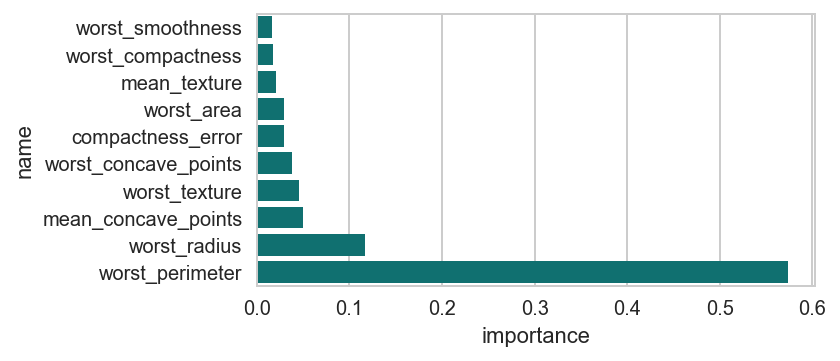

In [9]:
nTop = 10

df = pd.DataFrame({'name': model.feature_names_in_, 'importance': model.feature_importances_})
df = df.sort_values('importance')
df = df.query("importance > 0")
df = df.tail(nTop)

fig, ax = plt.subplots(figsize=(5,2.5))
sns.barplot(data=df, x='importance', y='name', color='teal')
plt.show()

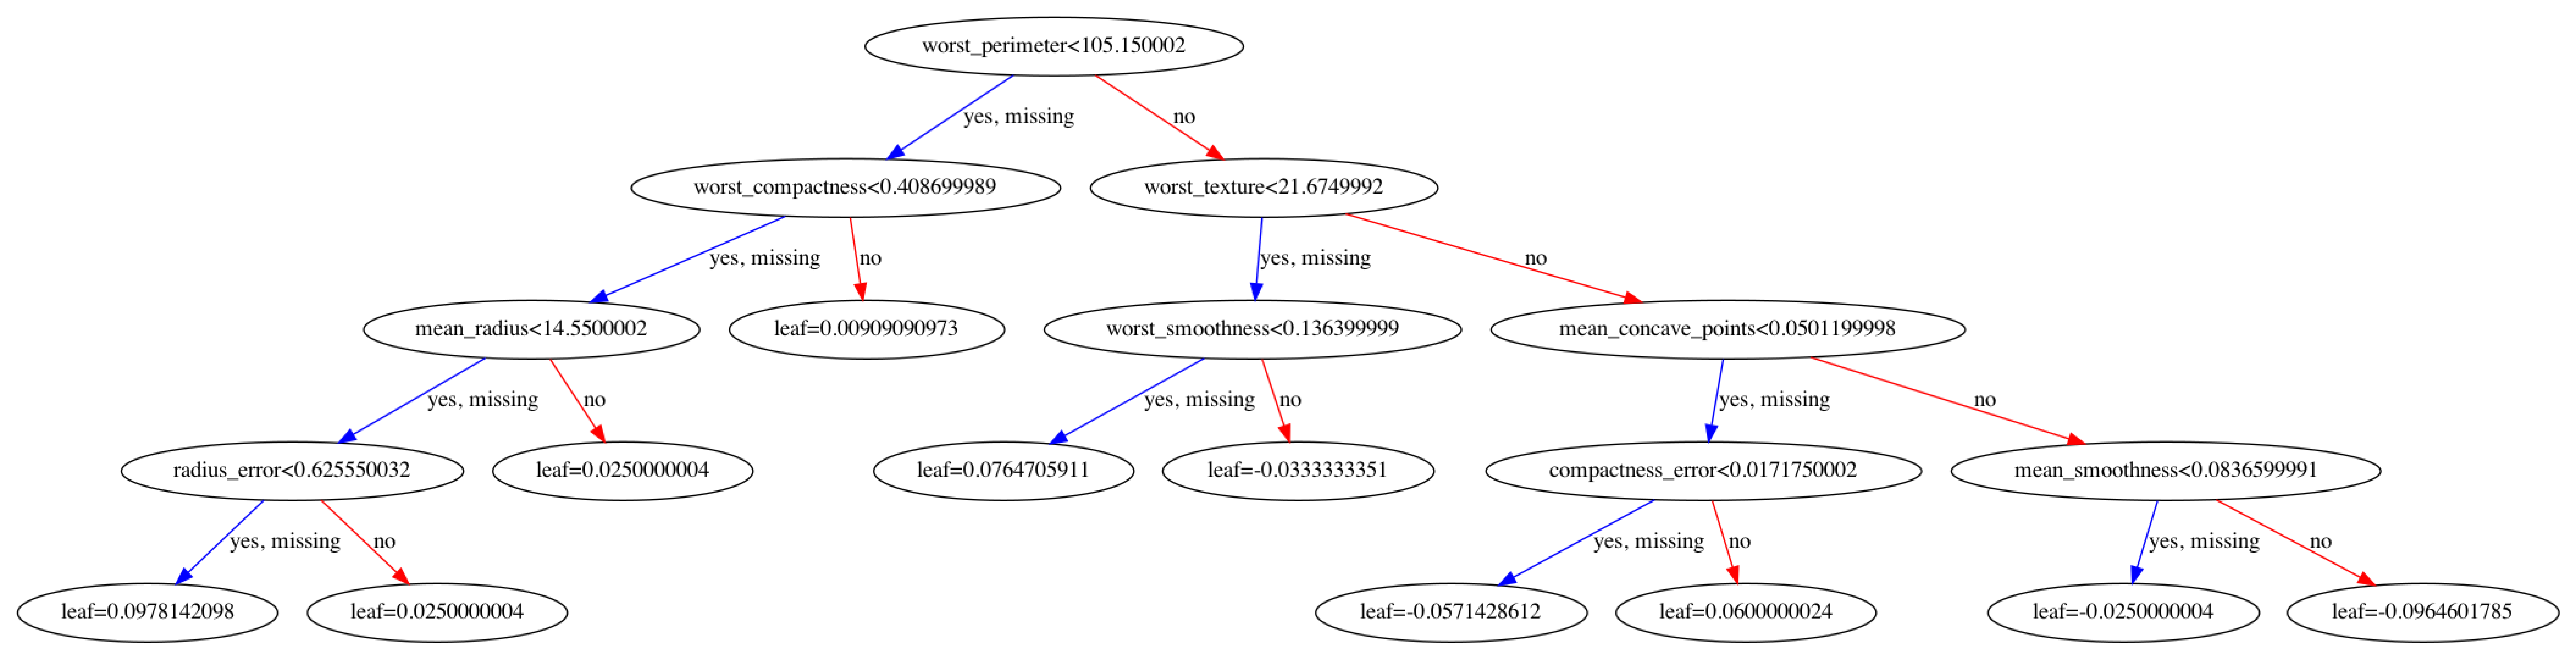

In [31]:
fig, ax = plt.subplots(figsize=(30,15), dpi=200)
xgb.plot_tree(model, ax=ax)
plt.show()

### XGBoost interface

In [17]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [18]:
dTrain = xgb.DMatrix(xTrain, yTrain)
dValid = xgb.DMatrix(xValid, yValid)
dTest = xgb.DMatrix(xTest, yTest)

In [19]:
nIter = 10

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.3,
    'max_leaves': 2**5,
}

callbacks = [
    xgb.callback.EarlyStopping(nIter*0.1),
    xgb.callback.EvaluationMonitor(period=5),
    xgb.callback.LearningRateScheduler(lambda i: 0.3+0.01*i),
    xgb.callback.TrainingCheckPoint(directory='output/xgboost', name='checkpoint', iterations=10),
]

model = xgb.train(
    params, dTrain,
    evals=[(dValid, 'valid'), (dTrain, 'train')],
    num_boost_round=nIter,
    callbacks=callbacks,
)

[0]	valid-logloss:0.47962	train-logloss:0.46577
[0]	valid-logloss:0.47962	train-logloss:0.46577
[1]	valid-logloss:0.35229	train-logloss:0.33031
[2]	valid-logloss:0.26789	train-logloss:0.24432
[3]	valid-logloss:0.21079	train-logloss:0.18088
[4]	valid-logloss:0.16759	train-logloss:0.13642
[5]	valid-logloss:0.13431	train-logloss:0.10408
[5]	valid-logloss:0.13431	train-logloss:0.10408
[6]	valid-logloss:0.11025	train-logloss:0.08186
[7]	valid-logloss:0.09418	train-logloss:0.06435
[8]	valid-logloss:0.08337	train-logloss:0.05263
[9]	valid-logloss:0.07342	train-logloss:0.04346
[9]	valid-logloss:0.07342	train-logloss:0.04346


In [20]:
yTestPred = model.predict(dTest) # predict probability
auc = AUC(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9659 [Booster]


### Multilabel problem

In [37]:
dfEmotionTrain = pd.read_csv('data/emotions_train.csv')
dfEmotionTest = pd.read_csv('data/emotions_test.csv')

xTrain = dfEmotionTrain.iloc[:, :-6]
yTrain = dfEmotionTrain.iloc[:, -6:]
xTest = dfEmotionTest.iloc[:, :-6]
yTest = dfEmotionTest.iloc[:, -6:]

print(xTrain.shape, yTrain.shape)

(391, 72) (391, 6)


In [38]:
start = dt.datetime.now()

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,6),
    'random_state': [2],
}

algo = XGBClassifier(
    # hyperparameters
    num_leaves=2**5,
    learning_rate=0.05,
    n_estimators=nIter,
    
    # configurations
    verbosity=0, silent=1,
    importance_type='gain',
    # callbacks=callbacks,
    eval_metric=['logloss', 'auc'],
)
model = algo.fit(
    xTrain, yTrain, 
)

print(dt.datetime.now() - start)

0:00:04.438000


In [39]:
yTestProb = model.predict_proba(xTest)
listAuc = AUC(yTest, yTestProb, average=None)
listAuc = listAuc.round(4).tolist()

print(f'AUC = {listAuc} [{model.__class__.__name__}]')

AUC = [0.8481, 0.6956, 0.815, 0.9551, 0.8248, 0.8852] [XGBClassifier]


## 1.4. Auto XGBoost

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score as AUC, fbeta_score as FScore
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from flaml import AutoML

In [5]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [20]:
start = dt.datetime.now()

model = AutoML(
    task='classification',
    metric='roc_auc',
    max_iter=100,
    time_budget=60,
    estimator_list=['xgboost'],
    eval_method='cv',
    n_splits=5,
    verbose=0,
)

model.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

0:00:30.719410


In [22]:
yTestPred = model.predict_proba(xTest)[: ,1]
auc = AUC(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9750 [AutoML]


# 2. LightGBM
[LightGBM](https://lightgbm.readthedocs.io/en/latest/) (**Light** **G**radient **B**oosting **M**achines) is an implementation of Gradient Boosting developed by Microsoft in 2016, in attempt to deal with large datasets. According to [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf), the main cost in GBDT lies in learning the decision trees, and the most time-consuming part in learning a decision tree is to find the best split points. XGBoost has developed histogram-based split finding that reduces the complexity of the algorithm from $O(\#instance \times \#feature)$ to $O(\#bin \times \#feature)$ where $\#bin\ll \#instance$, which outperforms other implementations in terms of memory consumption.

However, XGBoost still does not meet the satisfactory of scalability when working on large datasets. To improve the performance of previous implementations, LightGBM introduces two novels techniques, GOSS (**G**radient-based **O**ne-**S**ide **S**ampling) for reducing data instances and EFB (**E**xclusive **F**eature **B**undling) for reducing data dimensions.

## 2.1. Algorithm

### One-side sampling
As the purpose of GOSS is to smartly sample data, it requires sample weights to achieve this. Althought Gradient Boosting does not have any native weight as in Adaptive Boosting, we can use residuals (generally gradients) as pseudo-weights. The GOSS algorithm is implemented right before the training of each weak learner and is described as follows.

*Input:*
- A dataset of $N$ observations and their corresponding gradients computed from the most recent predictor
- $a$ - the sampling ratio of large gradient data and $b$ - the sampling ratio of small gradient data ($a+b$ should not be greater than $1$)

*Step 1:* Sort (in descending order) the observations by the absolute values of their gradients and select top $\lfloor aN \rfloor$ observations. This under-trained set is what the training of the next tree should focus on.

*Step 2:* Perform random sampling $\lfloor bN \rfloor$ observations from the rest of the data. In order to compensate the information losses that affect data distribution, each instance in this well-trained set is amplified by a constant $\dfrac{1-a}{b}>1$ when calculating information gain in the next tree. "One-side sampling" in fact means that sampling is done on the small gradient side.

*Step 3:* Combine the under-trained set and the well-trained set above to form a single set to be used in learning the Decision Tree. By using this technique, *we put more focus on the under-trained instances without changing the original data distribution by much*.

### Exclusive feature bundling
One of the biggest problems that occur in high dimensional data is the sparsity. Sparse features spend A specific case is when some features *never* or *rarely* take non-zero values *simultaneously*; such features are called *mutually exclusive*. A typical situation is that features returned by an one-hot encoder are perfectly mutually exclusive. This situation is rarely met in real-world datasets, thus the EFB algorithm allows a small fraction of conflicts. To achieve this, two questions need to be answered: (1) *Which features should be bundled together?* and (2) *How to construct the bundles?*.

*Step 1:* Greedy bundling.

- Construct a graph whose weights correspond the total conflicts between features, then order the features by their degrees in the graph in the descending order. By using this ordered list, we are priortizing features with high probability of having conflicts. Another ordering strategy which further improves the efficiency is sorting by the number of non-zero values.

- Check each feature in the ordered list, either assign it to an existing bundle if the conflict rate is smaller than a preconfigured constant, or create a new bundle.
   
*Step 2:* Merging exclusive features. The key is to ensure features' values do not overlap and can be identified after bundling. This can be achieve by adding an offset to the original values of each feature so that features reside in different bins. Assume a bundle has 3 features $\mathbf{x}_1$, $\mathbf{x}_2$ and $\mathbf{x}_3$; their values ranges are $[0,20)$, $[10,15)$ and $[0,5)$. We add to these features consecutively offset values of $0$, $20$ and $35$, resulting in new feature ranges of $[0,20)$, $[30,35)$ and $[35,40)$. Now it's safe to merge all the three features into a single bundle with range $[0,40)$.

The EFB algorithm is processed only once before training, however, because of having the complexity of $O(\#feature^2)$, it may still suffer if there are millions of features.

### Key features
- [Optimization in speed and memory usage](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-speed-and-memory-usage). As in XGBoost, LightGBM also uses histogram-based split finding and histogram substraction to reduce calculation cost.
- [Optimization in accuracy](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-accuracy). LightGBM grows trees leaf-wise instead of level-wise as in most Decision Tree learning algorithms. This strategy chooses the leaf with highest delta loss to grow. For the same amount of leaves, leaf-wise approach tends to achieve a lower bias. This may sometimes cause overfitting, but this issue can be address by decreasing the max depth or number of leaves of tress.
- [Categorical features support](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support). LightGBM has a built-in mechanism to work with categorical features.
- [Optimization in distributed learning](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-distributed-learning). LightGBM supports three parallelization algorithms which fit in different scenarios.

||Small data|Large data|
|:--|:--|:--|
|**Small dimensional**|Feature parallel|Data parallel|
|**High dimensional**|Feaure parallel|Voting parallel|

- [Continued training](https://lightgbm.readthedocs.io/en/latest/Parameters.html#continued-training-with-input-score). LightGBM can continue training with initial scores.
- [GPU support](https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html). LightGBM supports GPU training for accelaration.
- [DART](https://xgboost.readthedocs.io/en/stable/tutorials/dart.html). LightGBM also supports the DART boosting technique as XGBoost does.
- [Piece-Wise Linear Regression Trees](https://lightgbm.readthedocs.io/en/latest/Parameters.html#linear_tree).
- [Monotone constraints](https://lightgbm.readthedocs.io/en/latest/Parameters.html#monotone_constraints_method).
- [Cost efficient gradient boosting](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#cost-efficient-gradient-boosting).

## 2.2. Hyperparameters
The LightGBM algorithm has a huge number of [hyperparameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html), devided into many types. Some of them have aliases, which makes LightGBM compatible with other libraries. LightGBM has a [tuning guideline](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) page.

*Boosting parameters*. The configurations for boosting.
- <code style='font-size:13px; color:#BA2121'>boosting</code>: the ensemble method, defaults to *gdbt* (traditional GBM). Other options are *rf* (Random Forest), *goss* (Gradient-based One-Side Sampling) and *dart* (Dropouts meets Multiple Additive Regression Trees).
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *100*. Larger is usually better, but should go with a lower *learning_rate* and an *early_stopping_round* provided. Lower can speed up training.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *0.1*. Same usage as in GBM.
- <code style='font-size:13px; color:#BA2121'>early_stopping_round</code>: the maximum number of iterations without improvements, defaults to *0* (disabled). Keeping a low enough value may make boosting stop earlier, thus reduces the overall training time. Usually be set around $10\%$ of *n_estimators*.
- <code style='font-size:13px; color:#BA2121'>tree_learner</code>: the parallelization strategy, defaults to *serial* (single machine, no parallel). Other options are *feature*, *data* and *voting*.

*Bagging parameters*. LightGBM even includes more bagging parameters compared to Scikit-learn.
- <code style='font-size:13px; color:#BA2121'>bagging_fraction</code>: the ratio of data (instances) used in each tree, defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.
- <code style='font-size:13px; color:#BA2121'>bagging_freq</code>: the iteration frequency to perform bagging, defaults to *0* (disable bagging). A positive value will decrease the randomness between trees.
- <code style='font-size:13px; color:#BA2121'>pos_bagging_fraction</code> and <code style='font-size:13px; color:#BA2121'>neg_bagging_fraction</code>: the ratio of positive/negative samples used in each tree, both default to *1*. This pair of parameters should be used together to handle imbalance binary classification problems.
- <code style='font-size:13px; color:#BA2121'>feature_fraction</code>: the ratio of features used in each tree, defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.
- <code style='font-size:13px; color:#BA2121'>feature_fraction_bynode</code>: same as *feature_fraction*, but the sampling is done on tree nodes instead of trees; also defaults to *1*. A lower value can reduce overfitting but cannot speed up training.
- <code style='font-size:13px; color:#BA2121'>extra_trees</code>: whether to use Extremely Randomized Trees or not, defaults to *False*. This parameter increases the randomness, thus can deal with overfitting.

*Tree learning parameters*. Most parameters in this group are for prunning trees in order to deal with overfitting. Due to the fact that pruned trees are shallower, the training is also faster.
- <code style='font-size:13px; color:#BA2121'>num_leaves</code>: the maximum number of leaves in each tree, defaults to *31*. Since LightGBM grows trees leaf-wise, this is the main hyperparameter to control the complexity of trees. Optimal values range from $50\%$ to $100\%$ of $2^{\text{max_depth}}$.
- <code style='font-size:13px; color:#BA2121'>min_samples_leaf</code>: the minimum number of data a leaf must have, defaults to *20*. The next important parameter to prevent overfitting, its optimal value depends on training data size and *num_leaves*. Practical values for large datasets range from hundreds to thousands.
- <code style='font-size:13px; color:#BA2121'>max_depth</code>: the maximum depth of each tree, defaults to *-1* (no depth limitation). Another important parameter that controls overfitting; however, it is less effective on leaf-wise compared to level-wise implementations. A value from 3 to 13 works well for most datasets.
- <code style='font-size:13px; color:#BA2121'>min_sum_hessian_in_leaf</code>: the minimum sum of Hessian (the second derivative of the objective function for each observation) of each leaf, defaults to *0.001*. When the loss function is MSE, its second derivative is $1$; the sum of Hessian in this case equals to the number of data. For other loss function, this parameter has different meanings and also has different optimal values. Thus, unless you know what you are doing, this parameter should be left alone.
- <code style='font-size:13px; color:#BA2121'>min_gain_to_split</code>: the minimum information gain required to perform a split, defaults to *0*. In practice, very small improvements in the training loss have no meaningful impact on the generalization error of the model. A small value of this parameter is enough if used.
- <code style='font-size:13px; color:#BA2121'>reg_alpha</code> and <code style='font-size:13px; color:#BA2121'>reg_lambda</code>: the $L_1$ and $L_2$ regularization terms, both default to *0*. Optimal values are $10^k$ where $k$ is around $0$.
- <code style='font-size:13px; color:#BA2121'>linear_tree</code>: whether to use Piece-Wise Linear Regression Trees, defaults to *False*.
- <code style='font-size:13px; color:#BA2121'>linear_lambda</code>: the coefficient for linear tree regularization, defaults to *0*.

*Categorical split finding parameters*.
- <code style='font-size:13px; color:#BA2121'>categorical_feature</code>: specify categorical features, defaults to *auto*.
- <code style='font-size:13px; color:#BA2121'>min_data_per_group</code>: the minimum number of data per categorical group, defaults to *100*.
- <code style='font-size:13px; color:#BA2121'>cat_smooth</code>: the coefficient for categorical smoothing, defaults to *10*. Can reduce the effect of noises in categorical features, especially for ones with few data.
- <code style='font-size:13px; color:#BA2121'>max_cat_threshold</code>: the maximum number of splits considered for categorical features, defaults to *32*. Higher means more split points and larger search space. Lower reduces training time.
- <code style='font-size:13px; color:#BA2121'>cat_l2</code>: L2 regularization in categorical split, defaults to *10*.
- <code style='font-size:13px; color:#BA2121'>max_cat_to_onehot</code>: maximum number of categories of a feature to use one-hot encoding, otherwise the Fisher's split finding will be used, defaults to *4*.

*Histogram building parameters*.
- <code style='font-size:13px; color:#BA2121'>max_bin</code> and <code style='font-size:13px; color:#BA2121'>max_bin_by_feature</code>: the maximum number of bins when building histograms, defaults to *255*. The later parameter takes a list of intergers to specify the max number of bins for each feature. Smaller reduces training time but may hurt the accuracy.
- <code style='font-size:13px; color:#BA2121'>min_data_in_bin</code>: the minimum bin size, defaults to *3*. This parameter prevents bins from having a small number of data, as using their boundaries as splits isn’t likely to change the final model very much. Higher value reduces training time.
- <code style='font-size:13px; color:#BA2121'>bin_construct_sample_cnt</code>: the number of observations being sampled to determine bins, defaults to *200,000*. LightGBM only uses a part of data to find histogram boundaries, thus this parameter should not be set to a lower value. A higher value obviously improves prediction power but also leads to a longer data loading time.

*DART's parameters*
- <code style='font-size:13px; color:#BA2121'>drop_rate</code>: the fraction of previous trees to drop during the dropout, defaults to *0.1*.
- <code style='font-size:13px; color:#BA2121'>max_drop</code>: the max number of dropped trees during one boosting iteration, defaults to *50*.
- <code style='font-size:13px; color:#BA2121'>skip_drop</code>: the probability of skipping the dropout procedure during a boosting iteration, defaults to *0.5*.
- <code style='font-size:13px; color:#BA2121'>uniform_drop</code>: whether to use uniform drop or not, defaults to *False*.
- <code style='font-size:13px; color:#BA2121'>xgboost_dart_mode</code>: whether to enable XGBoost DART mode, which uses a bit different shrinkage rate, defaults to *False*.

*GOSS's parameters*
- <code style='font-size:13px; color:#BA2121'>top_rate</code>: the sampling ratio of large gradient data, defaults to *0.2*.
- <code style='font-size:13px; color:#BA2121'>other_rate</code>: the sampling ratio of small gradient data, defaults to *0.1*.

*Preprocessing parameteres*
- <code style='font-size:13px; color:#BA2121'>enable_bundle</code>: whether to use the EFB algorithm or not, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>enable_sparse</code>: whether to use sparse optimization, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>use_missing</code>: whether to use special handle of missing values, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>feature_pre_filter</code>: whether to ignore unsplittable features based on *min_samples_leaf*, defaults to *True*. As *min_samples_leaf* was set, some features will perform a split results in a leaf not having enough minimum number of data. Such features will be filtered out once before training. Also remember to tune *min_samples_leaf* before this parameter.

## 2.3. Implementation
LightGBM supports a lot of customizations and useful features:
- It accepts a wide range of different loss functions, can be either a [built-in one](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective), or a user-defined function with the signature:
<code style='font-size:13px'>loss(yTrue, yPred) -> (grad, hess)</code>.
- You can provide LightGBM validation sets and evaluation metrics, it will print out evaluation results at each stage. LightGBM allows you to control the logging frequency or even surpress it.
- It accepts either [built-in metrics](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric) or user-defined metrics with the signature:
<code style='font-size:13px'>eval(yTrue, yPred) -> (evalName, evalResult, isHigherBetter)</code>.
- It accepts validation set(s) and their corresponding names.
- You can create a [callback](<https://en.wikipedia.org/wiki/Callback_(computer_programming)>) that activates [early stopping](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.html) if one of the metrics doesn't improve after a number of rounds. At least one validation set must be provided to active early stopping.
- It can continue training if provided an existing model.
- LightGBM supports 2 feature importances calculating strategies: *split* (default) - the number of times a feature is used and *gain* - the total of information gain associated with a feature.
- You can specify a list of integer-encoded categorical features, since LightGBM has a special mechanism to work with them.

In [3]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

In [2]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

### Scikit-learn interface
The algorithm initialization syntax using
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html">LGBMClassifier</a></code>
and
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html">LGBMRegressor</a></code>
classes is the same as in Scikit-learn. Most of LightGBM's useful features are accessed using the
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier.fit">fit()</a></code>
method.

In [3]:
# create a model with 200 iterations
algo = LGBMClassifier(
    num_leaves=2**5,
    learning_rate=0.05,
    n_estimators=200,
    
    verbosity=-1,
    importance_type='gain',
)

# train the model with early stopping of 10% of number of trees
model = algo.fit(
    xTrain, yTrain,
    eval_set=[(xValid, yValid)],
    eval_names=['Valid'],
    eval_metric=['binary_logloss', 'auc'],
    callbacks=[
        lgb.early_stopping(20, first_metric_only=True),
        lgb.log_evaluation(period=20),
    ],
)

Training until validation scores don't improve for 20 rounds
[20]	Valid's binary_logloss: 0.245227	Valid's auc: 0.996284
[40]	Valid's binary_logloss: 0.129513	Valid's auc: 0.997635
[60]	Valid's binary_logloss: 0.0819823	Valid's auc: 0.998649
[80]	Valid's binary_logloss: 0.0640199	Valid's auc: 0.998986
[100]	Valid's binary_logloss: 0.0622647	Valid's auc: 0.998649
Early stopping, best iteration is:
[97]	Valid's binary_logloss: 0.0609187	Valid's auc: 0.998986
Evaluated only: binary_logloss


In [4]:
yTestPred = model.predict_proba(xTest)[: ,1]
auc = roc_auc_score(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9835 [LGBMClassifier]


In [5]:
model.feature_importances_

array([   2.7932,   61.9895,    0.7611,    0.3866,    3.8635,    0.4405,
        117.783 ,   96.1331,    3.7455,    0.2102,   10.3477,    5.8531,
         13.2454,   72.8923,    6.2065,    6.9134,    0.    ,   11.753 ,
          3.9254,    8.9424,  449.2814,  157.9406, 1878.1435,  754.576 ,
         44.5361,   43.9856,  241.9603,  494.7697,   21.146 ,    4.1357])

### LightGBM interface
Beside Scikit-learn API, LightGBM also provides its own training API via the
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html">train()</a></code>
function, which takes a
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html">Dataset</a></code>
object as input instead of NumPy arrays. The prediction step still takes NumPy arrays as input as in Scikit-learn. Learn more [here](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

In [10]:
listFeatureCategorical = []
dataTrain = lgb.Dataset(xTrain, yTrain)
dataValid = lgb.Dataset(xValid, yValid, reference=dataTrain)
dataTest = lgb.Dataset(xTest, yTest, reference=dataTrain)

In [19]:
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    
    'n_estimators': 200,
    'boosting_type': 'goss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    
    'verbose': -1,
    'force_col_wise': True
}
model = lgb.train(
    params=params,
    train_set=dataTrain,
    valid_sets=dataValid,
    callbacks=[
        lgb.early_stopping(20, first_metric_only=False),
        lgb.log_evaluation(period=20),
    ],
)

Training until validation scores don't improve for 20 rounds
[20]	valid_0's binary_logloss: 0.246778	valid_0's auc: 0.996622
[40]	valid_0's binary_logloss: 0.139876	valid_0's auc: 0.997297
[60]	valid_0's binary_logloss: 0.0911384	valid_0's auc: 0.997973
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.12314	valid_0's auc: 0.997973


In [23]:
yTestPred = model.predict(xTest)
auc = roc_auc_score(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9821 [Booster]


In [27]:
model.feature_importance('split')

array([ 3, 19,  4,  0,  9,  5, 12, 19,  3,  6, 10, 20,  7, 23,  5, 11,  2,
        5,  4,  3, 17, 20, 17, 20,  5,  8, 17, 46, 10,  3])

# 3. CatBoost
[CatBoost](https://en.wikipedia.org/wiki/Catboost) (**Cat**egorical **Boost**ing) is a variant of Gradient Boosting developed by Yandex in 2017. CatBoost introduces *ordered encoding* and *ordered boosting*, two advanced algorithms to fight *prediction shift*, a special kind of target leakage presents in all other Graddient Boosting implementations. The implementation of CatBoost prepares default values for each hyperparameter carefully, which makes CatBoost works well without many effort in hyperparameter tuning.

## 3.1. Algorithm

### Ordered encoding
First, let's talk about a popular method in encoding categorical features: target encoding. This method simply replaces each category ($x_k$) of *a feature* $\mathbf{x}$ by the mean of *the target* ($\mathbf{y}$) of the corresponding *subset* ($\mathbf{1}_{\{x_n=x_k\}}$). It is formally given by:

$$x_k\leftarrow
\frac
  {\sum_{n=1}^{N}\mathbf{1}_{\{x_n=x_k\}}y_n+a\bar{y}}
  {\sum_{n=1}^{N}\mathbf{1}_{\{x_n=x_k\}}+a}$$

Here, $a$ is a smoothing parameter that pushes the encoding value towards the target mean $\bar{y}$. This encoding strategy easily leads to *target leakage*, when the distribution of $\mathbf{x}$ given $\mathbf{y}$ differs for training and test data.

To handle this, CatBoost applies the above formula in an innovative way. It shuffles the dataset at each boosting iteration and uses the current order as an *artifical time*. Then, to encode a value $x_n$, CatBoost uses all available *historical data* $\mathcal{D}_n=\{x_i,y_i\}_{i=1}^{n-1}$ to encode using the above formula. At first glance, this method looks wrong as it assigns different encoded values to the same category. That's why CatBoost uses different permutations at different steps of gradient boosting procedure. This also means ordered encoding principle only works in gradient boosting where there a lot of iterations, and it does not work well standalone.

### Ordered boosting
In previous Gradient Boosting techniques, each weak model is built sequentially based on the same dataset. CatBoost authors argue that there is some kind of target leakage across iterations, which is called *prediction shift*.

To combat this, CatBoost authors propose a variant called Ordered Boosting, a method using the same principle with Ordered Encoding. The main difference of this method is that the residual of each data point is calculated using a model fitted on *historical data*. CatBooost also prepares a number of random permutations used in split finding and choosing leaf values, in order to neutralize the variance in the final prediction.

### Key features
- [Categorical features transformation](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic). The most iconic feature of the algorithm.
- [Text features transformation](https://catboost.ai/en/docs/concepts/algorithm-main-stages_text-to-numeric).
- [Quantization](https://catboost.ai/en/docs/concepts/quantization). CatBoost also support histogram-based split finding like XGBoost and LightGBM do, but it goes one step further by supporting many choices of quantization modes.
- [GPU support](https://catboost.ai/en/docs/features/training-on-gpu). Like XGBoost and LightGBM, CatBoost also supports GPU training.
- [Overfitting detector](https://catboost.ai/en/docs/concepts/overfitting-detector). CatBoost has a built-in mechanism that can stop the training earlier if overfitting occurs.
- [Proceed training](https://catboost.ai/en/docs/features/proceed-training).
- [Bootstrap options](https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options). CatBoost supports different sampling options which gives regularization effect and speed up training.
- [Symmetric trees](https://catboost.ai/en/docs/concepts/parameter-tuning#tree-growing-policy). An interesting feature that CatBoost supports. This type of tree gives regularization effect, boosts computational performance and reduces the need of pruning trees.

## 3.2. Hyperparameters
CatBoost has a huge number of [hyperparameters](https://catboost.ai/en/docs/references/training-parameters/), devided into many types. Some of them have aliases, which makes CatBoost compatible with other libraries. CatBoost has a [tuning guideline](https://catboost.ai/en/docs/concepts/parameter-tuning) page.

*Boosting parameters*. The configurations for boosting.
- <code style='font-size:13px; color:#BA2121'>boosting_type</code>: the boosting type, defaults to *plain* (normal gradient boosting). The other option is *ordered* (ordered boosting).
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *1000*. Larger is usually better, but should go with a lower *learning_rate*.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *None* (automatically defined).
- <code style='font-size:13px; color:#BA2121'>early_stopping_rounds</code>: the maximum number of iterations without improvements, defaults to *False* (disabled). Keeping a low enough value may make boosting stop earlier, thus reduces the overall training time. Usually be set around $10\%$ of *n_estimators*.
- <code style='font-size:13px; color:#BA2121'>od_type</code>: the type of overfitting detector to use, defaults to *IncToDec*. The other option is *Iter*.

*Bagging parameters*.
- <code style='font-size:13px; color:#BA2121'>bootstrap_type</code>: strategy for sampling data, defaults to *None* (automatically defined). CatBoost supports *Bayesian*, *Bernoulli*, *MVS* and *Poisson*.
- <code style='font-size:13px; color:#BA2121'>subsample</code>: the ratio of data for sampling, defaults to *None* (automatically defined).
- <code style='font-size:13px; color:#BA2121'>sampling_frequency</code>: the frequency to sample when building trees, defaults to *PerTreeLevel*. The other option is *PerTree*.

*Tree learning parameters*. Most parameters in this group are for prunning trees in order to deal with overfitting and increasing training speed. If symmetric tree is used, most parameters in this group are not neccessary.
- <code style='font-size:13px; color:#BA2121'>grow_policy</code>: the tree construction strategry, defaults to *SymmetricTree*. Other options are *Depthwise* and *Lossguide*.
- <code style='font-size:13px; color:#BA2121'>min_data_in_leaf</code>: the minimum number of data a leaf must have, defaults to *1*. Cannot be used with *SymmetricTree*.
- <code style='font-size:13px; color:#BA2121'>max_leaves</code>: the maximum number of leaves in each tree, defaults to *31*. Can only work with *Lossguide*.
- <code style='font-size:13px; color:#BA2121'>l2_leaf_reg</code>: the $L_2$ regularization term, defaults to *3*.

*Histogram building parameters*.
- <code style='font-size:13px; color:#BA2121'>border_count</code>: the maximum number of cut points when building histograms, defaults to *254*.
- <code style='font-size:13px; color:#BA2121'>feature_border_type</code>: the quantization mode for numerical features, defaults to *GreedyLogSum*. Other options are *Median*, *Uniform*, *UniformAndQuantiles*, *MaxLogSum* and *MinEntropy*.
- <code style='font-size:13px; color:#BA2121'>per_float_feature_quantization</code>: this parameter is used to specify *border_count* and *feature_border_type* for each feature.

*Categorical handling parameters*.
- <code style='font-size:13px; color:#BA2121'>cat_features</code> and
<code style='font-size:13px; color:#BA2121'>text_features</code>:
the list of indices or names of categorical/text features, default to *None*.
- <code style='font-size:13px; color:#BA2121'>one_hot_max_size</code>: the maximum number of categories of a feature to use one-hot encoding, otherwise use CatBoost's encoder, defaults to *None* (automatically defined).
- <code style='font-size:13px; color:#BA2121'>model_size_reg</code>: the [regularization](https://catboost.ai/en/docs/references/model-size-reg) term for the size of a model contributed by categorical features, defaults to *0.5*. Larger values reduce model size.
- <code style='font-size:13px; color:#BA2121'>max_ctr_complexity</code>: the maximum number of features that can be combined, defaults to *4*. Has to be less than *15*.
- <code style='font-size:13px; color:#BA2121'>simple_ctr</code> and
<code style='font-size:13px; color:#BA2121'>combinations_ctr</code>:
settings for encoding a single/combination of categorical features. These are both complex parameters with a lot of settings, but they share the same format. Please refer to CatBoost's [documentation](https://catboost.ai/en/docs/references/training-parameters/ctr#simple_ctr) for detailed usage.

## 3.2. Implementation
CatBoost support a lot of customizations and useful features. Please refer to CatBoost's [tutorials](https://github.com/catboost/catboost/tree/master/catboost/tutorials) for more details.
- It accepts either a [built-in loss function](https://catboost.ai/en/docs/references/custom-metric__supported-metrics) or a [custom loss function](https://catboost.ai/en/docs/concepts/python-usages-examples#user-defined-loss-function) with the signature:
<code style='font-size:13px'>loss(yPred, yTrue) -> (grad, hess)</code>.
- It accepts either a [built-in evaluation metric](https://catboost.ai/en/docs/references/eval-metric__supported-metrics) or a [custom metric](https://catboost.ai/en/docs/concepts/python-usages-examples#custom-loss-function-eval-metric).
- It provides a lot of [model analysis](https://catboost.ai/en/docs/concepts/model-analysis) tools, including
[feature importance](https://catboost.ai/en/docs/concepts/fstr) and
[object importance](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_get_object_importance).
- It supports [snapshotting](https://catboost.ai/en/docs/features/snapshots), which periodically saves the current state of the model. This allows recovering training after an interuption by launching the training in the same folder with the same parameters.

In [28]:
import datetime as dt
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as AUC
from catboost import CatBoostClassifier, CatBoostRegressor
import catboost as cgb

In [2]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

### Scikit-learn interface
The algorithm initialization syntax using
<code style='font-size:13px'><a href="https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier">CatBoostClassifier</a></code>
and
<code style='font-size:13px'><a href="https://catboost.ai/en/docs/concepts/python-reference_catboostregressor">CatBoostRegressor</a></code>
classes is the same as in Scikit-learn. Most of CatBoost's useful features are accessed using the
<code style='font-size:13px'><a href="https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_fit">fit()</a></code>
method.

In [73]:
algo = CatBoostClassifier(
    boosting_type='Ordered',
    n_estimators=500,
    max_depth=3,
    early_stopping_rounds=50,
    
    # eval_metric='Logloss', # for evaluation
    custom_metric=['AUC', 'F1', 'CrossEntropy'], # for displaying only
    train_dir='output/catboost',
    save_snapshot=False,
    snapshot_interval=600,
)

model = algo.fit(
    xTrain, yTrain,
    eval_set=[(xValid, yValid)],
    verbose=100,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.032843
0:	learn: 0.6456139	test: 0.6406496	best: 0.6406496 (0)	total: 7.19ms	remaining: 3.59s
100:	learn: 0.0687001	test: 0.0543116	best: 0.0543116 (100)	total: 270ms	remaining: 1.07s
200:	learn: 0.0361472	test: 0.0392240	best: 0.0392240 (200)	total: 531ms	remaining: 790ms
300:	learn: 0.0173880	test: 0.0336209	best: 0.0335770 (296)	total: 764ms	remaining: 505ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03301641292
bestIteration = 342

Shrink model to first 343 iterations.


In [74]:
yPred = model.predict(xTest)
auc = AUC(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9524 [CatBoostClassifier]


### Model analysis

In [107]:
dTrain = cgb.Pool(xTrain, yTrain)
model.get_feature_importance(type='PredictionValuesChange', prettified=True).head()

,Feature Id,Importances
0,worst_perimeter,11.716592
1,worst_area,10.885156
2,worst_concave_points,9.509133
3,mean_concave_points,8.031246
4,worst_concavity,6.975604


In [106]:
dTrain = cgb.Pool(xTrain, yTrain)
model.get_feature_importance(data=dTrain, type='LossFunctionChange', prettified=True).head()

,Feature Id,Importances
0,area_error,0.009007
1,worst_area,0.009000
2,worst_concavity,0.007121
3,worst_concave_points,0.006818
4,mean_concave_points,0.005860


In [119]:
dTrain = cgb.Pool(xTrain, yTrain)
model.get_feature_importance(data=dTrain, type='Interaction', prettified=True).head()

,First Feature Index,Second Feature Index,Interaction
0,23,26,5.117987
1,13,24,5.069373
2,17,23,3.986848
3,23,27,3.222103
4,7,13,2.652889


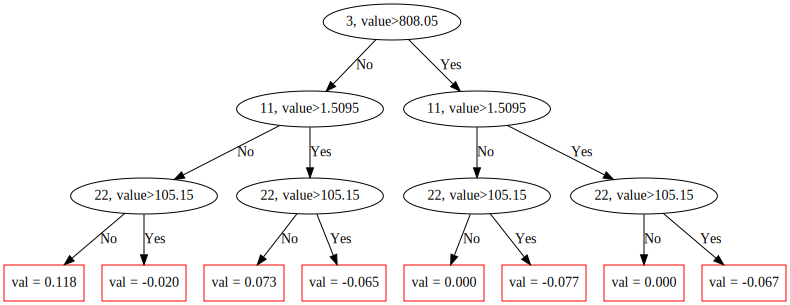

In [76]:
model.plot_tree(tree_idx=7)

### CatBoost interface

In [121]:
dTrain = cgb.Pool(xTrain, yTrain)
dValid = cgb.Pool(xValid, yValid)
dTest = cgb.Pool(xTest, yTest)

In [133]:
params = {
    'boosting_type': 'Ordered',
    'n_estimators': 500,
    'max_depth': 3,
    'early_stopping_rounds': 50,
    'allow_writing_files': False,
}

model = cgb.train(
    pool=dTrain, evals=dValid,
    params=params,
    verbose=100,
)

Learning rate set to 0.06564
0:	learn: 0.4636810	test: 0.4538482	best: 0.4538482 (0)	total: 2.75ms	remaining: 1.37s
100:	learn: 0.1374874	test: 0.1252798	best: 0.1252506 (99)	total: 219ms	remaining: 864ms
200:	learn: 0.1025667	test: 0.1185282	best: 0.1185282 (200)	total: 394ms	remaining: 586ms
300:	learn: 0.0868420	test: 0.1136188	best: 0.1136188 (300)	total: 570ms	remaining: 377ms
400:	learn: 0.0736333	test: 0.1091781	best: 0.1090910 (395)	total: 743ms	remaining: 183ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1090909577
bestIteration = 395

Shrink model to first 396 iterations.


In [132]:
yTestPred = model.predict(dTest) # predict probability
auc = AUC(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9901 [CatBoost]


### Multilabel problem

In [17]:
dfEmotionTrain = pd.read_csv('data/emotions_train.csv')
dfEmotionTest = pd.read_csv('data/emotions_test.csv')

xTrain = dfEmotionTrain.iloc[:, :-6]
yTrain = dfEmotionTrain.iloc[:, -6:]
xTest = dfEmotionTest.iloc[:, :-6]
yTest = dfEmotionTest.iloc[:, -6:]

print(xTrain.shape, yTrain.shape)

(391, 72) (391, 6)


In [35]:
start = dt.datetime.now()

algo = CatBoostClassifier(
    # hyperparameters
    boosting_type='Ordered',
    learning_rate=None,
    n_estimators=200,
    early_stopping_rounds=20,
    
#     # configurations
    loss_function='MultiLogloss',
    allow_writing_files=False,
    verbose=50,
)
model = algo.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

Learning rate set to 0.030182
0:	learn: 0.6783843	total: 442ms	remaining: 1m 28s
50:	learn: 0.3692859	total: 23.4s	remaining: 1m 8s
100:	learn: 0.2811259	total: 49.9s	remaining: 48.9s
150:	learn: 0.2236028	total: 1m 14s	remaining: 24.3s
199:	learn: 0.1837092	total: 1m 38s	remaining: 0us
0:01:38.843101


In [36]:
yTestProb = model.predict_proba(xTest)
listAuc = AUC(yTest, yTestProb, average=None)
listAuc = listAuc.round(4).tolist()

print(f'AUC = {listAuc} [{model.__class__.__name__}]')

AUC = [0.8626, 0.7567, 0.8027, 0.9346, 0.843, 0.9159] [CatBoostClassifier]


# 4. NGBoost
NGBoost (**N**atural **G**radient **Boost**ing) is published in 2018 by Duan and Avati in order to add probabilistic *prediction interval* to point estimation which is typically seen in most regression algorithms. However, unlike XGBoost, LightGBM and CatBoost who integrate so many hyperparameters, optimizations, suppports and customizations; NGBoost's implementation is quite simple.

## 4.1. Algorithm
*Input*: mostly the same as other tree boosting algorithms, with some differences:
- A *parametric distribution* $\mathcal{P}$ (for example, normal distribution with two parameters mean and standard deviation) that you think our data follows.
- A *scoring function* $\mathcal{S}$ which evaluates the closeness between $\mathcal{P}$ and the observed label (think of it as the alternative for loss function in normal gradient boosting). NGBoost currently supports two options for $\mathcal{S}$, *log likelihood* and *continuous ranked probability*.

*Algorithm*: Being a boosting algorithm, NGBoost uses the same behaviour as normal gradient boosting. But instead of updating directly the predicted values of weak learners, NGBoost fit a sequence of trees *for each parameter* of the distribution $\mathcal{P}$ so that the scoring function is minimized at each step. However, according to NGBoost's paper, the *distance* between two parameter values does not correspond to an appropriate *distance* between the distributions that those parameters identify. This motivates the *natural gradient*, thus the name of the algorithm.

## 4.2. Implementation
- <code style='font-size:13px; color:#BA2121'>Dist</code>: the distribution to be used, defaults to *normal distribution* (for regression) and *categorical distribution* (for classification). Being a class provided by NGBoost.
- <code style='font-size:13px; color:#BA2121'>Score</code>: the scoring rule to be used, defaults to *log score*. Being a class provided by NGBoost.
- <code style='font-size:13px; color:#BA2121'>Base</code>: the base estimator, being 
- <code style='font-size:13px; color:#BA2121'>natural_gradient</code>: whether to use natural gradient or not, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages, defaults to *500*. Larger is usually better, but should go with a lower *learning_rate* and an *early_stopping_rounds* provided. Lower can speed up training.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate, defaults to 0.01. Same usage as in GBM.
- <code style='font-size:13px; color:#BA2121'>minibatch_frac</code>
and <code style='font-size:13px; color:#BA2121'>col_sample</code>:
the ratio of instances/features used in each tree, both defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.

In [2]:
import datetime as dt
import numpy as np; np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2
from sklearn.tree import DecisionTreeRegressor
from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import Poisson, Bernoulli, k_categorical, ClassificationDistn
from ngboost.distns import Normal, Laplace, Cauchy, Exponential, RegressionDistn
from ngboost.scores import LogScore, CRPScore

In [6]:
dfBoston = pd.read_csv('data/boston.csv')
dfBoston.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
x = dfBoston.copy()
y = x.pop('price')
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=7)

In [8]:
start = dt.datetime.now()

nIter = 1000

algo = NGBRegressor(
    Dist=Normal,
    Score=LogScore,
    Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=3),
    n_estimators=nIter,
    learning_rate=0.01,
    minibatch_frac=0.5,
    col_sample=0.5,
    
    verbose_eval=nIter/5,
    random_state=7,
)

model = algo.fit(
    xTrain, yTrain,
    xTest, yTest,
    # early_stopping_rounds=int(nIter/5)
)

end = dt.datetime.now()
print(end - start)

[iter 0] loss=3.6106 val_loss=3.6037 scale=1.0000 norm=6.7694
[iter 200] loss=2.2211 val_loss=2.4719 scale=2.0000 norm=3.5080
[iter 400] loss=1.9163 val_loss=2.6082 scale=1.0000 norm=1.5952
[iter 600] loss=1.7287 val_loss=2.9839 scale=1.0000 norm=1.4241
[iter 800] loss=1.6338 val_loss=3.4870 scale=1.0000 norm=1.3173
0:00:07.316115


In [9]:
yTestPred = model.predict(xTest)
r2Test = R2(yTest, yTestPred)
modelName = model.__class__.__name__

print(f'R2 = {r2Test:.4f} [{modelName}]')

R2 = 0.8455 [NGBRegressor]


In [10]:
model.feature_importances_

array([[0.0927, 0.0091, 0.0445, 0.0088, 0.0669, 0.1906, 0.0847, 0.1422,
        0.0255, 0.0529, 0.0441, 0.0823, 0.1556],
       [0.0971, 0.0244, 0.0541, 0.0098, 0.0732, 0.1563, 0.1043, 0.1235,
        0.024 , 0.0595, 0.0522, 0.0822, 0.1393]])

>*Problem*: For each house in the test set, use the distribution parameters (mean and standard deviation) returned by NGBoost to find:
>- The probability that house price lies within the range $(20,25)$
>- The interval of price with $95\%$ confidence

In [6]:
from scipy import stats
muTest, sigmaTest = model.pred_dist(xTest).params.values()
dist = stats.norm(muTest, sigmaTest)

In [7]:
alpha = 0.05

pd.DataFrame({
    'True': yTest.values,
    'MeanPredict': muTest.round(2),
    'Proba(20,25)': (dist.cdf(25) - dist.cdf(20)).round(6),
    'Lower(95%)': dist.ppf(alpha/2).round(2),
    'Upper(95%)': dist.isf(alpha/2).round(2),
})

,True,MeanPredict,"Proba(20,25)",Lower(95%),Upper(95%)
0,21.7,23.31,0.962086,21.45,25.17
1,18.5,19.26,0.192169,17.60,20.93
2,22.2,20.80,0.775838,18.74,22.85
3,20.4,19.91,0.467780,17.77,22.05
4,8.8,5.13,0.000000,2.93,7.33
...,...,...,...,...,...
97,16.3,11.41,0.000097,6.90,15.93
98,17.2,14.49,0.000018,11.87,17.10
99,28.0,27.11,0.003637,25.57,28.65
100,15.2,17.79,0.016172,15.77,19.81


# References
- *scikit-learn.org* - [Scikit-learn's ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)
- *xgboost.readthedocs.io* - [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/index.html)
- *lightgbm.readthedocs.io* - [LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/)
- *stanfordmlgroup.github.io* - [NGBoost documentation](https://stanfordmlgroup.github.io/ngboost/intro.html)
- *catboost.ai* - [CatBoost documentation](https://catboost.ai/en/docs/)
- *cs.columbia.edu* - [A short introduction to Boosting](http://www.cs.columbia.edu/~jebara/6772/papers/IntroToBoosting.pdf)
- *arxiv.org* - [XGBoost: A scalable tree boosting system](https://arxiv.org/pdf/1603.02754.pdf)
- *arxiv.org* - [CatBoost: Unbiased Boosting with categorical features](https://arxiv.org/pdf/1706.09516.pdf)
- *arxiv.org* - [NGBoost: Natural Gradient Boosting for probabilistic prediction](https://arxiv.org/pdf/1910.03225.pdf)
- *arxiv.org* - [DART: Dropouts meet Multiple Additive Regression Trees](https://arxiv.org/pdf/1505.01866.pdf)
- *arxiv.org* - [Gradient Boosting with Piece-Wise Linear Regression Trees](https://arxiv.org/pdf/1802.05640.pdf)
- *papers.nips.cc* - [LightGBM: A highly efficient Gradient Boosting Decision Tree](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
- *papers.nips.cc* - [Cost efficient gradient boosting](https://papers.nips.cc/paper/2017/file/4fac9ba115140ac4f1c22da82aa0bc7f-Paper.pdf)
- *towardsdatascience.com* - [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)
- *deep-and-shallow.com* - [The Gradient Booster IV(B): NGBoost](https://deep-and-shallow.com/2020/06/27/the-gradient-boosters-vib-ngboost/)

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*